In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense , Dropout ,LSTM
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [3]:
# load the four data sets
df1 = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
df2 = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv')
df3 = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv')
df4 = pd.read_csv('NKE_2006-01-01_to_2018-01-01.csv')
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.tail()

,Date,Open,High,Low,Close,Volume,Name
12072,2017-12-22,61.20,63.54,60.13,63.29,20414195,NKE
12073,2017-12-26,62.90,63.89,62.81,63.65,4563475,NKE
12074,2017-12-27,63.56,63.60,62.77,62.95,8959745,NKE
12075,2017-12-28,63.00,63.32,62.85,62.95,3987151,NKE
12076,2017-12-29,63.21,63.37,62.55,62.55,5222115,NKE


In [4]:
# visualize data to chack if there is missing values in High column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12077 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


In [5]:
# take the data that we interested in 
df_train = df['High']
print(df_train.tail())

12072    63.54
12073    63.89
12074    63.60
12075    63.32
12076    63.37
Name: High, dtype: float64


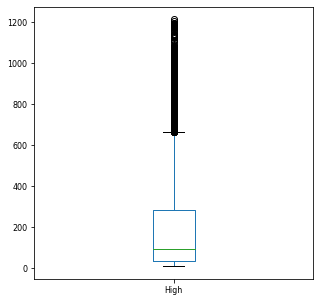

In [107]:
# plot the High data 
fig = plt.figure(figsize = (5,5))
df_train.plot(kind='box',fontsize=8)
plt.show()

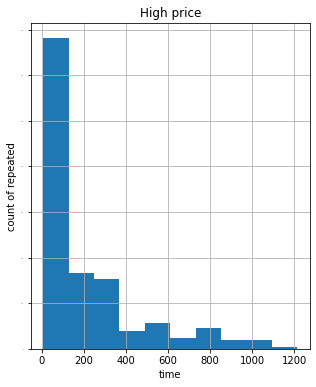

In [154]:
fig = plt.figure(figsize = (5,6))
df_train.hist(ylabelsize=1)
plt.title("High price")
plt.xlabel('time')
plt.ylabel('count of repeated')
plt.show()

In [8]:
# drop the raws that contain nans
df_train = df_train.dropna()
print(df_train.tail())

12072    63.54
12073    63.89
12074    63.60
12075    63.32
12076    63.37
Name: High, dtype: float64


In [9]:
# prepar the  data 
scaler = MinMaxScaler(feature_range=(0,1))
Data_Scaled = scaler.fit_transform(df_train.values.reshape(-1,1))
Data_Scaled.shape

(12077, 1)

In [10]:
# split the data to train and test data
prediction_Days = 60 # will in the memory
X_train = []
Y_train = []
# every 60 raw in x will match 1 raw in y 
for i in range(prediction_Days,len(Data_Scaled)): 
    X_train.append(Data_Scaled[i-prediction_Days:i,0]) 
    Y_train.append(Data_Scaled[i,0])

X_train,Y_train = np.array(X_train),np.array(Y_train)
X_train = X_train.reshape(-1,prediction_Days,1)

In [71]:
# build the model
def create_baseline():
    model = Sequential()

    model.add(LSTM(units=50, return_sequences = True, input_shape =(prediction_Days,1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units =1))

    model.compile(optimizer='adam',loss="mean_squared_error")
    return model

In [72]:
# convert the model to keras to can apply gridSearch on it 
estimator = KerasRegressor(build_fn=create_baseline)

In [73]:
# prepare the estimator prameters 
params={'batch_size':[60,70,80], 
        'nb_epoch':[3,5,8,10],}

In [74]:
# grid search config.
grid_search = GridSearchCV(estimator=estimator, param_grid=params, cv=3)
# now fit the dataset to the GridSearchCV object. 
grid_search  = grid_search .fit(X_train, Y_train)

201/201 [==============================] - 24s 100ms/step - loss: 0.0031


In [153]:
# to Know the best batch size and the number of epoch
print(grid_search.best_params_)

{'batch_size': 60, 'nb_epoch': 8}


In [80]:
# train the model 
model = create_baseline()
model.fit(X_train, Y_train, epochs = 8, batch_size =60)

Epoch 1/8
201/201 [==============================] - 24s 97ms/step - loss: 0.0030
Epoch 2/8
201/201 [==============================] - 20s 98ms/step - loss: 0.0014
Epoch 3/8
201/201 [==============================] - 20s 97ms/step - loss: 0.0013
Epoch 4/8
201/201 [==============================] - 19s 96ms/step - loss: 0.0010
Epoch 5/8
201/201 [==============================] - 19s 96ms/step - loss: 0.0011
Epoch 6/8
201/201 [==============================] - 19s 96ms/step - loss: 9.2514e-04
Epoch 7/8
201/201 [==============================] - 19s 96ms/step - loss: 8.5925e-04
Epoch 8/8
201/201 [==============================] - 20s 99ms/step - loss: 8.5432e-04


In [81]:
# prepare test data 
test_data =pd.read_csv('Google_test_data.csv')
train_data = df
actual_price = test_data['High'].values
total_dataset = pd.concat((train_data['High'],test_data['High']))
model_input = total_dataset[len(total_dataset) - len(test_data) - prediction_Days :].values
model_input = model_input.reshape(-1,1)
model_input = scaler.fit_transform(model_input)

In [82]:
# split the data to take the test data 
X_test = []
for i in range(prediction_Days,len(model_input)):
  X_test.append(model_input[i-prediction_Days:i,0])
X_test = np.array(X_test)
X_test = X_test.reshape(-1,prediction_Days,1)

In [83]:
# predict the test data 
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price.shape

(252, 1)

In [98]:
# get the accuracy of the number 61
actual_price.reshape(-1,1)
accurecy = predicted_price[60]/actual_price[60]
print(accurecy)

[0.98226345]


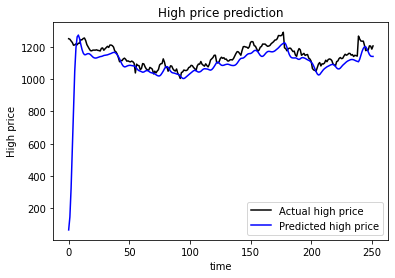

In [152]:
# compare between actual data and the predicted data 
plt.plot(actual_price, color= "black", label ="Actual high price")
plt.plot(predicted_price, color= "blue", label ="Predicted high price")
plt.title("High price prediction")
plt.xlabel('time')
plt.ylabel('High price')
plt.legend()